In [1]:
# 1. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2. Load the dataset
df = pd.read_csv("ChildBehaviourAnalysis.csv")
print("Shape:", df.shape)
df.head(5)

Shape: (200, 9)


,Age,Gender,Sleep_Hours,Study_Hours,Play_Hours,Screen_Time,Meals_Per_Day,Mood,Behavior_Category
0,14,Female,8.9,3.0,1.0,0.3,5,Angry,Healthy
1,6,Female,8.8,2.1,1.0,0.3,4,Happy,Healthy
2,11,Female,8.4,3.5,1.3,0.9,3,Happy,Healthy
3,14,Male,8.8,3.5,1.2,0.9,4,Happy,Healthy
4,9,Male,9.3,3.6,1.2,0.6,5,Happy,Healthy


In [3]:
# Define top 5 features based on importance
top_features = ['Play_Hours', 'Screen_Time', 'Study_Hours', 'Meals_Per_Day', 'Sleep_Hours']
target_column = 'Behavior_Category'

# Drop rows with missing values in selected features or target
df = df[top_features + [target_column]].dropna()

df.sample(5)

,Play_Hours,Screen_Time,Study_Hours,Meals_Per_Day,Sleep_Hours,Behavior_Category
94,1.9,1.6,1.1,2,7.3,Needs Improvement
29,1.4,0.4,3.6,5,8.4,Healthy
177,2.6,1.6,2.1,2,6.4,Needs Improvement
44,3.9,3.6,0.8,2,5.2,Unhealthy
179,2.3,2.2,2.2,3,7.0,Needs Improvement


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Play_Hours         200 non-null    float64
 1   Screen_Time        200 non-null    float64
 2   Study_Hours        200 non-null    float64
 3   Meals_Per_Day      200 non-null    int64  
 4   Sleep_Hours        200 non-null    float64
 5   Behavior_Category  200 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB


In [5]:
df.isnull().sum()

Play_Hours           0
Screen_Time          0
Study_Hours          0
Meals_Per_Day        0
Sleep_Hours          0
Behavior_Category    0
dtype: int64

In [6]:
df["Behavior_Category"].value_counts()  # Clearly shows here it is imbalanced dataset

Behavior_Category
Needs Improvement    120
Healthy               40
Unhealthy             40
Name: count, dtype: int64

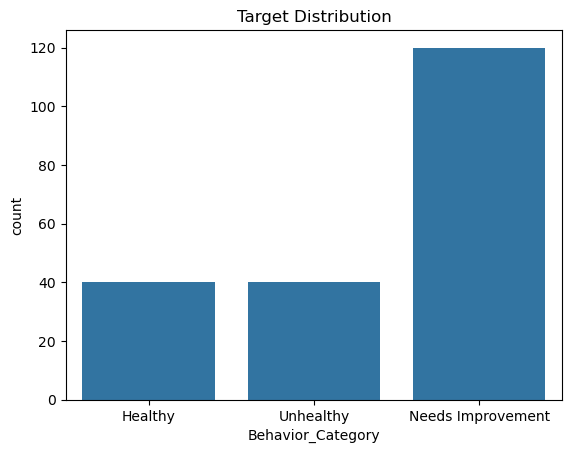

In [7]:
# EDA - Class distribution
sns.countplot(x="Behavior_Category", data=df)
plt.title("Target Distribution")
plt.show()

In [8]:
df.columns

Index(['Play_Hours', 'Screen_Time', 'Study_Hours', 'Meals_Per_Day',
       'Sleep_Hours', 'Behavior_Category'],
      dtype='object')

In [9]:
numerical_col = [i for i in df.columns if df[i].dtype in ['int64', 'float64']]
print(numerical_col)

['Play_Hours', 'Screen_Time', 'Study_Hours', 'Meals_Per_Day', 'Sleep_Hours']


In [10]:
categorical_col = [col for col in df.columns if col not in numerical_col]

print(categorical_col)

['Behavior_Category']


In [11]:
# Encode categorical columns
label_encoders = {}
df_encoded = df.copy()
for col in categorical_col:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

In [12]:
df_encoded.head(5)

,Play_Hours,Screen_Time,Study_Hours,Meals_Per_Day,Sleep_Hours,Behavior_Category
0,1.0,0.3,3.0,5,8.9,0
1,1.0,0.3,2.1,4,8.8,0
2,1.3,0.9,3.5,3,8.4,0
3,1.2,0.9,3.5,4,8.8,0
4,1.2,0.6,3.6,5,9.3,0


In [13]:
label_encoders

{'Behavior_Category': LabelEncoder()}

In [14]:
X= df_encoded.iloc[:,:-1].to_numpy()
y= df_encoded.iloc[:,-1].to_numpy()

In [15]:
X

array([[1. , 0.3, 3. , 5. , 8.9],
       [1. , 0.3, 2.1, 4. , 8.8],
       [1.3, 0.9, 3.5, 3. , 8.4],
       [1.2, 0.9, 3.5, 4. , 8.8],
       [1.2, 0.6, 3.6, 5. , 9.3],
       [1.2, 0.8, 2.8, 4. , 8.8],
       [1.2, 0.7, 2. , 3. , 8.1],
       [0.8, 0.2, 2.4, 3. , 8.3],
       [1.1, 0.5, 3.3, 4. , 8.8],
       [0.5, 0.4, 2.7, 4. , 9.9],
       [1.1, 0.8, 3.8, 5. , 9.6],
       [1.5, 0.9, 2.7, 3. , 8.8],
       [1.3, 0.6, 3.2, 5. , 9.4],
       [1.2, 0.4, 2.7, 5. , 9.2],
       [1.1, 0.8, 2.7, 4. , 8.9],
       [0.9, 0.7, 2.8, 5. , 8.2],
       [0.9, 0.9, 2.7, 4. , 8.7],
       [1.2, 0.5, 3.4, 3. , 9.4],
       [0.8, 0.4, 3.5, 3. , 9.2],
       [1. , 0.4, 2.5, 4. , 9.9],
       [1. , 0.5, 3. , 5. , 8.5],
       [0.8, 0.5, 2.3, 4. , 8.3],
       [1.5, 0.9, 2.4, 4. , 9.7],
       [1.2, 0.7, 3.3, 4. , 9.3],
       [1. , 0.5, 3. , 3. , 9.4],
       [0.7, 0.6, 2.8, 4. , 8.7],
       [1. , 0.3, 2.5, 3. , 9.1],
       [0.7, 0.5, 2.1, 3. , 9. ],
       [0.8, 0.9, 3.2, 5. , 9.9],
       [1.4, 0

In [16]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [17]:
# Train-Test Split (BEFORE any resampling/scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
y_train.mean()

1.0

In [19]:
y_test.mean()

1.0

In [20]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# SMOTE (ONLY on the scaled training data)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [22]:
classifier = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, splitter = 'random') 
classifier.fit(X_train_resampled, y_train_resampled)       

DecisionTreeClassifier(max_depth=5, splitter='random')

In [23]:
y_pred = classifier.predict(X_test_scaled)

In [24]:
acc = accuracy_score(y_test, y_pred)
acc

1.0

In [25]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 8,  0,  0],
       [ 0, 24,  0],
       [ 0,  0,  8]], dtype=int64)

In [26]:
clf_report = classification_report(y_test, y_pred)

print(clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00         8

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [27]:
# Save best model
print(f"\nSaving the model")
joblib.dump(classifier, "childmodel.pkl")
joblib.dump(scaler, "scaler1.pkl")
joblib.dump(label_encoders, "label_encoders1.pkl")

print("Saved: childmodel.pkl, scaler1.pkl, label_encoders1.pkl")

# print("Saved: best_model1.pkl, scaler1.pkl")



Saving the model
Saved: childmodel.pkl, scaler1.pkl, label_encoders1.pkl
